In [77]:
!pip3 install pyspark

In [111]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import DecisionTreeRegressor

In [112]:
# Create a Spark session
spark = SparkSession.builder.appName("MLExample").getOrCreate()

# Load your data into a Spark DataFrame
df = spark.read.csv('apple.csv', header=True, inferSchema=True)

In [80]:
df.show()

+---+------+-------------------+-------+-------+--------+-------+--------+-----------+-----------+-----------+-----------+---------+-------+-----------+
|_c0|symbol|               date|  close|   high|     low|   open|  volume|   adjClose|    adjHigh|     adjLow|    adjOpen|adjVolume|divCash|splitFactor|
+---+------+-------------------+-------+-------+--------+-------+--------+-----------+-----------+-----------+-----------+---------+-------+-----------+
|  0|  AAPL|2015-05-27 00:00:00|132.045| 132.26|  130.05| 130.34|45833246|121.6825575|121.8806851|119.8441183|120.1113601| 45833246|    0.0|          1|
|  1|  AAPL|2015-05-28 00:00:00| 131.78| 131.95|   131.1| 131.86|30733309|121.4383538|121.5950128|120.8117179|121.5120757| 30733309|    0.0|          1|
|  2|  AAPL|2015-05-29 00:00:00| 130.28| 131.45|   129.9| 131.23|50884452|120.0560687|121.1342511|119.7058898| 120.931516| 50884452|    0.0|          1|
|  3|  AAPL|2015-06-01 00:00:00|130.535| 131.39|  130.05|  131.2|32112797|120.2910

In [113]:
from pyspark.sql.functions import mean

mean_value = df.select(mean(df['adjHigh'])).collect()[0][0]
df = df.na.fill(mean_value, subset=['adjHigh'])

mean_value1 = df.select(mean(df['adjLow'])).collect()[0][0]
df = df.na.fill(mean_value1, subset=['adjLow'])

mean_value2 = df.select(mean(df['adjOpen'])).collect()[0][0]
df = df.na.fill(mean_value2, subset=['adjOpen'])


In [82]:
df.printSchema()
df.show(5)
df.describe().show()

root
 |-- _c0: integer (nullable = true)
 |-- symbol: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- close: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- open: double (nullable = true)
 |-- volume: integer (nullable = true)
 |-- adjClose: double (nullable = true)
 |-- adjHigh: double (nullable = false)
 |-- adjLow: double (nullable = false)
 |-- adjOpen: double (nullable = false)
 |-- adjVolume: integer (nullable = true)
 |-- divCash: double (nullable = true)
 |-- splitFactor: integer (nullable = true)

+---+------+-------------------+-------+-------+------+------+--------+-----------+-----------+-----------+-----------+---------+-------+-----------+
|_c0|symbol|               date|  close|   high|   low|  open|  volume|   adjClose|    adjHigh|     adjLow|    adjOpen|adjVolume|divCash|splitFactor|
+---+------+-------------------+-------+-------+------+------+--------+-----------+-----------+-----------+-------

In [114]:
df.groupBy("symbol").count().show()

from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="symbol", outputCol="symbol_index")
indexed_df = indexer.fit(df).transform(df)

+------+-----+
|symbol|count|
+------+-----+
|  AAPL| 1258|
+------+-----+



In [115]:
from pyspark.sql.functions import mean, expr  # Import expr here

# Calculate lower and upper bounds for outlier detection
def calculate_bounds(df, col_name, lower_bound_factor=1.5, upper_bound_factor=1.5):
    q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower_bound = q1 - (lower_bound_factor * iqr)
    upper_bound = q3 + (upper_bound_factor * iqr)
    return lower_bound, upper_bound

columns_to_check = ["close", "high", "low", "open", "volume", "adjClose", "adjHigh", "adjLow", "adjOpen", "adjVolume"]

for col_name in columns_to_check:
    lower_bound, upper_bound = calculate_bounds(df, col_name)
    df = df.withColumn(col_name + "_outlier", expr(f"{col_name} < {lower_bound} OR {col_name} > {upper_bound}"))

# Show records where 'close' is an outlier
df.filter("close_outlier = true").show()

+----+------+-------------------+------+------+--------+--------+--------+-----------+-----------+-----------+-----------+---------+-------+-----------+-------------+------------+-----------+------------+--------------+----------------+---------------+--------------+---------------+-----------------+
| _c0|symbol|               date| close|  high|     low|    open|  volume|   adjClose|    adjHigh|     adjLow|    adjOpen|adjVolume|divCash|splitFactor|close_outlier|high_outlier|low_outlier|open_outlier|volume_outlier|adjClose_outlier|adjHigh_outlier|adjLow_outlier|adjOpen_outlier|adjVolume_outlier|
+----+------+-------------------+------+------+--------+--------+--------+-----------+-----------+-----------+-----------+---------+-------+-----------+-------------+------------+-----------+------------+--------------+----------------+---------------+--------------+---------------+-----------------+
|1177|  AAPL|2020-01-29 00:00:00|324.34|327.85|  321.38|  324.45|54149928|322.7082456|326.2005

In [116]:
rmse_list = []
rmse_list1 = []

In [86]:
filtered_df = df.filter("close_outlier = false AND high_outlier = false AND low_outlier = false AND open_outlier = false")

In [87]:
from pyspark.sql.functions import log

transformed_df = df.withColumn("log_close", log(df["close"]))
transformed_df.show()

+---+------+-------------------+-------+-------+--------+-------+--------+-----------+-----------+-----------+-----------+---------+-------+-----------+-------------+------------+-----------+------------+--------------+----------------+---------------+--------------+---------------+-----------------+------------------+
|_c0|symbol|               date|  close|   high|     low|   open|  volume|   adjClose|    adjHigh|     adjLow|    adjOpen|adjVolume|divCash|splitFactor|close_outlier|high_outlier|low_outlier|open_outlier|volume_outlier|adjClose_outlier|adjHigh_outlier|adjLow_outlier|adjOpen_outlier|adjVolume_outlier|         log_close|
+---+------+-------------------+-------+-------+--------+-------+--------+-----------+-----------+-----------+-----------+---------+-------+-----------+-------------+------------+-----------+------------+--------------+----------------+---------------+--------------+---------------+-----------------+------------------+
|  0|  AAPL|2015-05-27 00:00:00|132.0

In [88]:
#FEACTURE SCALING MINMAX
assembler = VectorAssembler(inputCols=["close"], outputCol="close_vector")
vectorized_df = assembler.transform(df)

scaler = StandardScaler(inputCol="close_vector", outputCol="scaled_features_scale", withStd=True, withMean=True)
scaled_df = scaler.fit(vectorized_df).transform(vectorized_df)

In [89]:
split_ratio = [0.7, 0.3]

train_df, test_df = df.randomSplit(split_ratio)

In [117]:
#LINEAR REGRESSION
feature_cols = [
    'close',
    'high',
    'low',
    'open',
    'volume',
    'adjClose',
    'adjHigh',
    'adjLow',
    'adjOpen',
    'adjVolume',
    'divCash',
    'splitFactor'
]

vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_df = vector_assembler.transform(train_df)
test_df = vector_assembler.transform(test_df)

lr = LinearRegression(featuresCol="features", labelCol="close")

lr_model = lr.fit(train_df)

predictions = lr_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")

IllegalArgumentException: Output column features already exists.

In [108]:
#PIPELINE(LINEAR REGRESSION)
feature_cols = ["high", "low", "open", "volume", "adjClose", "adjHigh", "adjLow", "adjOpen", "adjVolume"]

# Define the target column
target_col = "close"

vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

lr = LinearRegression(featuresCol="scaled_features", labelCol=target_col)

evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")

pipeline = Pipeline(stages=[vector_assembler, scaler, lr])

train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

pipeline_model = pipeline.fit(train_df)

predictions = pipeline_model.transform(test_df)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")
rmse_list.append(rmse)

AssertionError: 

In [92]:
#PIPELINE(RANDOM FOREST)
spark = SparkSession.builder.appName("RandomForestRegressionExample").getOrCreate()

feature_cols = ["high", "low", "open", "volume", "adjClose", "adjHigh", "adjLow", "adjOpen", "adjVolume"]

target_col = "close"

vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

rf = RandomForestRegressor(featuresCol="features", labelCol=target_col, numTrees=100, maxDepth=5)

evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")

pipeline = Pipeline(stages=[vector_assembler, rf])

train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

pipeline_model = pipeline.fit(train_df)

predictions = pipeline_model.transform(test_df)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")
rmse_list.append(rmse)

Root Mean Squared Error (RMSE): 2.538030579316499


In [93]:
spark = SparkSession.builder.appName("DecisionTreeRegressionExample").getOrCreate()

feature_cols = ["high", "low", "open", "volume", "adjClose", "adjHigh", "adjLow", "adjOpen", "adjVolume"]
target_col = "close"

# Define a Vector Assembler to combine features
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Create a Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol=target_col, maxDepth=5)

# Create a Regression Evaluator
evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")

# Create a pipeline
pipeline = Pipeline(stages=[vector_assembler, dt])

# Split the data into training and testing sets
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# Fit the pipeline on the training data
pipeline_model = pipeline.fit(train_df)

# Make predictions on the test data
predictions = pipeline_model.transform(test_df)

# Evaluate the model
rmse = evaluator.evaluate(predictions)
rmse_list.append(rmse)
print(f"Root Mean Squared Error (RMSE): {rmse}")
spark.stop()

Root Mean Squared Error (RMSE): 3.287771252662108


In [103]:
print(rmse_list)

[]


In [ ]:
#dataset
# Load your data into a Spark DataFrame
df = spark.read.csv('bda.csv', header=True, inferSchema=True)
# Define your feature columns
feature_cols = ["high", "low", "open", "volume", "adjClose", "adjHigh", "adjLow", "adjOpen", "adjVolume"]

# Define your target column
target_col = "close"

# Create a VectorAssembler to assemble features with 'handleInvalid' set to 'skip'
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")

# Transform the DataFrame with the VectorAssembler
df = vector_assembler.transform(df)

# Split the data into a training set and a test set
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

In [96]:
#LINEAR REGRESSION(HYPERPARAMETER)
# Create a Spark session
spark = SparkSession.builder.appName("LinearRegressionHyperparameterTuning").getOrCreate()

# Create a LinearRegression instance
lr = LinearRegression(labelCol=target_col, featuresCol="features")

# Define a grid of hyperparameters to search
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Create a CrossValidator with a RegressionEvaluator
evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")

crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5
)

# Split the data into a training set and a test set
# train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# Fit the cross-validation model
cv_model = crossval.fit(train_df)

# Evaluate the best model on the test set
best_model = cv_model.bestModel
predictions = best_model.transform(test_df)
rmse = evaluator.evaluate(predictions)

# Print the best hyperparameters and RMSE
print("Best hyperparameters:")
print(f"RegParam: {best_model.getRegParam()}")
print(f"ElasticNetParam: {best_model.getElasticNetParam()}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
rmse_list1.append(rmse)

Best hyperparameters:
RegParam: 0.01
ElasticNetParam: 0.0
Root Mean Squared Error (RMSE): 0.4101403839042678


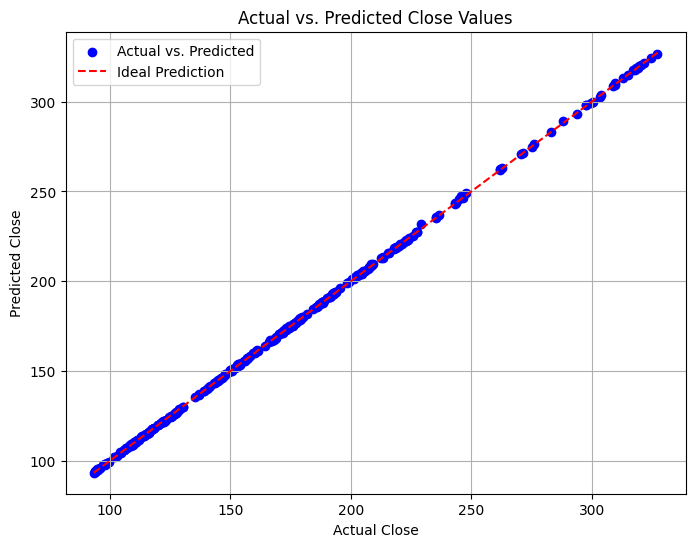

In [97]:
import matplotlib.pyplot as plt

# Extract actual and predicted values from the DataFrame
actual_values = predictions.select("close").rdd.map(lambda x: x[0]).collect()
predicted_values = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, color='blue', label='Actual vs. Predicted')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('Actual Close')
plt.ylabel('Predicted Close')
plt.title('Actual vs. Predicted Close Values')
plt.legend()
plt.grid(True)
plt.show()

spark.stop()

In [98]:
#RANDOM FOREST(HYPERPARAMETER)
# Create a Spark session
spark = SparkSession.builder.appName("RandomForestHyperparameterTuning").getOrCreate()

"""
df = spark.read.csv('bda.csv', header=True, inferSchema=True)
# Defining feature columns
feature_cols = ["high", "low", "open", "volume", "adjClose", "adjHigh", "adjLow", "adjOpen", "adjVolume"]

# Defining target column
target_col = "close"

# Create a VectorAssembler to assemble features with 'handleInvalid' set to 'skip'
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")

# Transform the DataFrame with the VectorAssembler
df = vector_assembler.transform(df)
"""
# Create a RandomForestRegressor instance
rf = RandomForestRegressor(labelCol=target_col, featuresCol="features")

# Define a grid of hyperparameters to search
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Create a CrossValidator with a RegressionEvaluator
evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")

crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5  # You can adjust the number of folds for cross-validation
)

# Split the data into a training set and a test set
#train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# Fit the cross-validation model
cv_model = crossval.fit(train_df)

# Evaluate the best model on the test set
best_model = cv_model.bestModel
predictions = best_model.transform(test_df)
rmse = evaluator.evaluate(predictions)

# Print the best hyperparameters and RMSE
print("Best hyperparameters:")
print(f"Number of Trees: {best_model.getNumTrees}")
print(f"Max Depth: {best_model.getMaxDepth}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
rmse_list1.append(rmse)

Best hyperparameters:
Number of Trees: 100
Max Depth: <bound method _DecisionTreeParams.getMaxDepth of RandomForestRegressionModel: uid=RandomForestRegressor_570f705b1990, numTrees=100, numFeatures=9>
Root Mean Squared Error (RMSE): 2.971664035696954


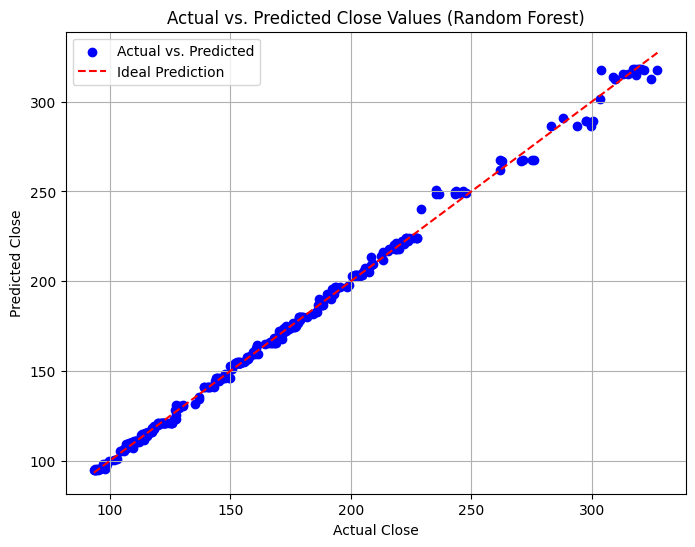

In [99]:
import matplotlib.pyplot as plt

# Extract actual and predicted values from the DataFrame
actual_values = predictions.select("close").rdd.map(lambda x: x[0]).collect()
predicted_values = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, color='blue', label='Actual vs. Predicted')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('Actual Close')
plt.ylabel('Predicted Close')
plt.title('Actual vs. Predicted Close Values (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

# Stop the Spark session
spark.stop()

In [100]:
# Create a Spark session
spark = SparkSession.builder.appName("DecisionTreeHyperparameterTuning").getOrCreate()

"""
# Load your data into a Spark DataFrame
df = spark.read.csv('bda.csv', header=True, inferSchema=True)
# Define your feature columns
feature_cols = ["high", "low", "open", "volume", "adjClose", "adjHigh", "adjLow", "adjOpen", "adjVolume"]

# Define your target column
target_col = "close"

# Create a VectorAssembler to assemble features with 'handleInvalid' set to 'skip'
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")

# Transform the DataFrame with the VectorAssembler
df = vector_assembler.transform(df)
"""
# Create a DecisionTreeRegressor instance
dt = DecisionTreeRegressor(labelCol=target_col, featuresCol="features")

# Define a grid of hyperparameters to search
param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .build()

# Create a CrossValidator with a RegressionEvaluator
evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")

crossval = CrossValidator(
    estimator=dt,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5  # You can adjust the number of folds for cross-validation
)

# Split the data into a training set and a test set
#train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# Fit the cross-validation model
cv_model = crossval.fit(train_df)

# Evaluate the best model on the test set
best_model = cv_model.bestModel
predictions = best_model.transform(test_df)
rmse = evaluator.evaluate(predictions)

# Print the best hyperparameters and RMSE
print("Best hyperparameters:")
print(f"Max Depth: {best_model.getMaxDepth}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
rmse_list1.append(rmse)

Best hyperparameters:
Max Depth: <bound method _DecisionTreeParams.getMaxDepth of DecisionTreeRegressionModel: uid=DecisionTreeRegressor_681a408c4a81, depth=5, numNodes=63, numFeatures=9>
Root Mean Squared Error (RMSE): 3.4064158544475234


In [104]:
print(rmse_list1)

[0.4101403839042678, 2.971664035696954, 3.4064158544475234]


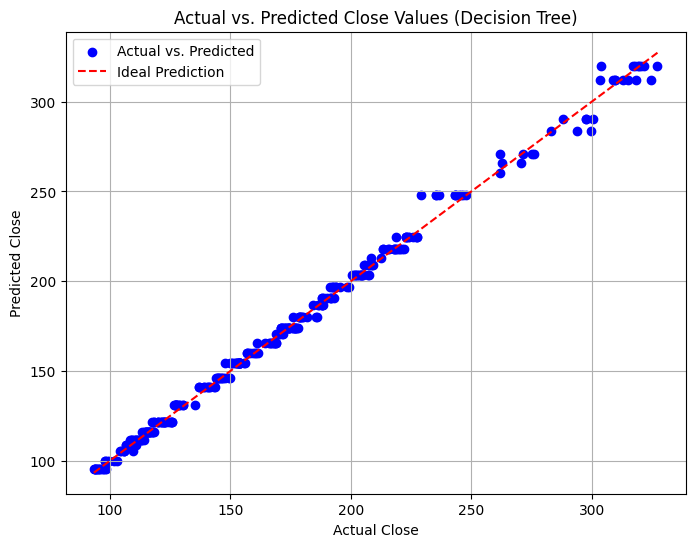

In [101]:
import matplotlib.pyplot as plt

# Extract actual and predicted values from the DataFrame
actual_values = predictions.select("close").rdd.map(lambda x: x[0]).collect()
predicted_values = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, color='blue', label='Actual vs. Predicted')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('Actual Close')
plt.ylabel('Predicted Close')
plt.title('Actual vs. Predicted Close Values (Decision Tree)')
plt.legend()
plt.grid(True)
plt.show()

# Stop the Spark session
spark.stop()

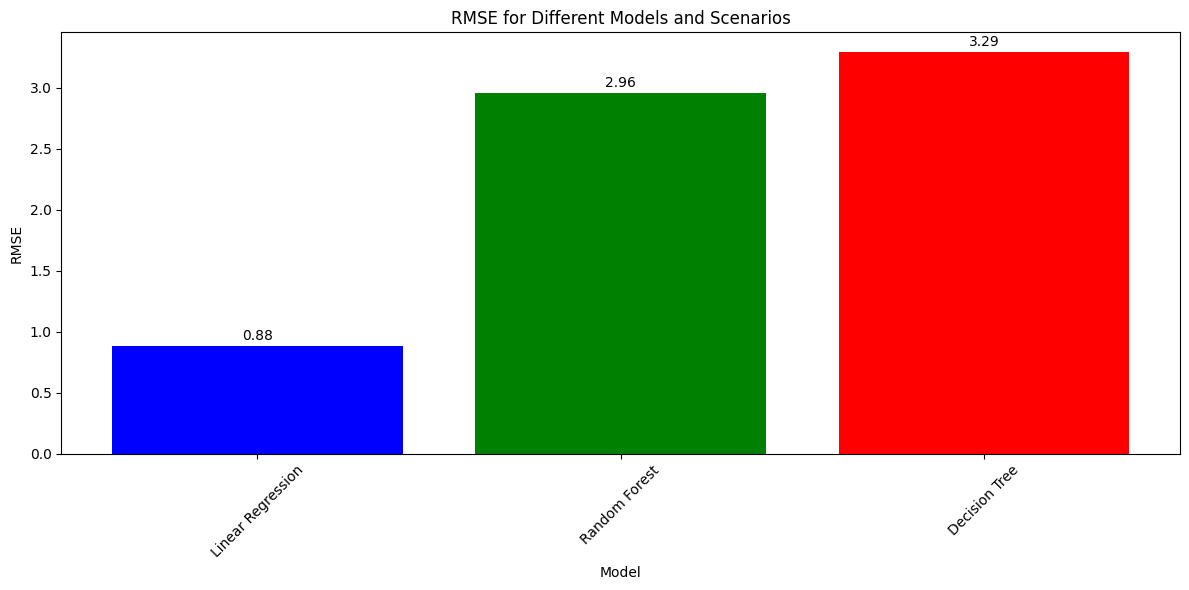

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

# Data in a dictionary format
data = {
    'Model': ['Linear Regression', 'Random Forest', 'Decision Tree'],
    'RMSE':  rmse_list, #[0.8828016353667498, 2.9551702074453693, 3.287771252662108],
    'Scenario': ['Pipeline', 'Hyperparameter Tuning', 'Pipeline']
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(df['Model'], df['RMSE'], color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE for Different Models and Scenarios')

# Add RMSE values on the bars
for bar, rmse in zip(bars, df['RMSE']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, round(rmse, 2), ha='center')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


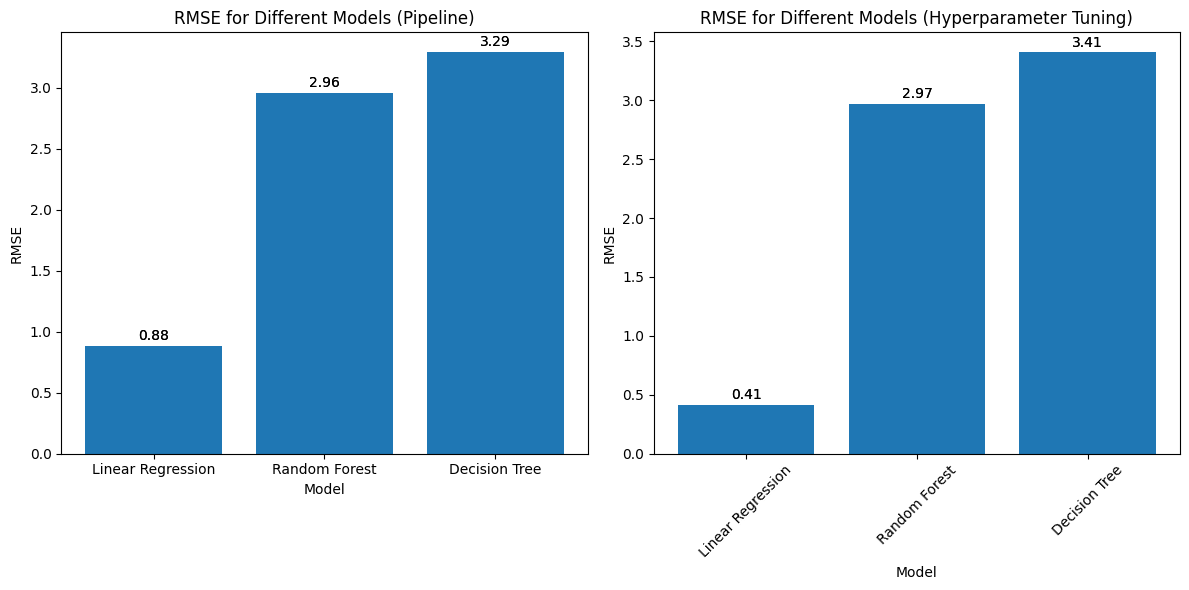

In [107]:
# Data in a dictionary format
data = {
    'Model': ['Linear Regression', 'Random Forest', 'Decision Tree'],
    'RMSE':  rmse_list, #[0.8828016353667498, 2.9551702074453693, 3.287771252662108],
    'RMSE1': rmse_list1, #[0.4101403839042678, 2.3494646640449324, 3.2264158544475234]
}

# Add 'Pipeline' and 'Hyperparameter Tuning' for each model
models = ['Pipeline', 'Hyperparameter Tuning']
data['Model'] = [model for model in data['Model'] for _ in models]
data['RMSE'] = [data['RMSE'][i // 2] for i in range(len(data['Model']))]
data['RMSE1'] = [data['RMSE1'][i // 2] for i in range(len(data['Model']))]

# Create a DataFrame
df = pd.DataFrame(data)

# Create two separate bar plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
bars = plt.bar(df['Model'], df['RMSE'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE for Different Models (Pipeline)')

for bar, rmse in zip(bars, df['RMSE']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, round(rmse, 2), ha='center')

plt.subplot(1, 2, 2)
bars = plt.bar(df['Model'], df['RMSE1'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE for Different Models (Hyperparameter Tuning)')

for bar, rmse in zip(bars, df['RMSE1']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, round(rmse, 2), ha='center')

plt.xticks(rotation=45)
plt.tight_layout()

# Show the plots
plt.show()
